# De belles cartes avec python : mise en pratique

Lino Galiana  
2024-09-23

La pratique de la cartographie se fera, dans ce cours, en répliquant des cartes qu’on peut trouver sur
la page de l’*open-data* de la ville de Paris
[ici](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name).

<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Note</h3>

Produire de belles cartes demande du temps mais aussi du bon sens. En fonction de la structure des données, certaines représentations sont à éviter voire à exclure. Un guide [disponible ici](https://juliedjidji.github.io/memocarto/semio.html) propose quelques règles et évoque les erreurs à éviter lorsqu’on désire effectuer des
représentations spatiales.
Celui-ci reprend un [guide de sémiologie cartographique](https://www.insee.fr/fr/statistiques/3640429)
produit par l’Insee qui propose de nombreux conseils pratiques pour produire des représentations
cartographiques sensées.

</div>

Ce TP vise à initier :

-   Au module graphique de [geopandas](https://geopandas.org/mapping.html) ainsi qu’aux packages [geoplot](https://residentmario.github.io/geoplot/index.html) et
    [contextily](https://contextily.readthedocs.io/en/latest/intro_guide.html) pour la construction de cartes figées. `geoplot` est construit sur `seaborn` et constitue ainsi une extension des graphiques de base.
-   Au package [folium](https://python-visualization.github.io/folium/) qui est un point d’accès vers la librairie JavaScript [leaflet](https://leafletjs.com/) permettant de produire des cartes interactives

Les données utilisées sont :

-   Un sous-ensemble des données de [paris open data](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name) a été mis à disposition
    sur `Github` pour faciliter l’import (élimination des colonnes
    qui ne nous servirons pas mais ralentissent l’import)
-   [La localisation précise des stations](https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr)
-   [Arrondissements parisiens](https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr)

<div class="alert alert-danger" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left: .2rem solid #ff0039;">
<h3 class="alert-heading"><i class="fa fa-exclamation-triangle"></i> Attention</h3>

Certaines librairies géographiques dépendent de `rtree` qui est parfois difficile à installer car
ce *package* dépend de librairies compilées qui sont compliquées à installer sur `Windows`.
Pour installer `rtree` sur `Windows`, le mieux est d’utiliser `Anaconda`.

</div>

Avant de pouvoir commencer, il est nécessaire d’installer quelques
packages au préalable:

In [1]:
# Sur colab
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas
!pip install geoplot

Dans la première partie, nous allons utiliser les packages suivants :

In [2]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import geoplot
import matplotlib.pyplot as plt
import folium


ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed

# 1. Première carte avec l’API `matplotlib` de `geopandas`

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 1: Importer les données</h3>

Importer les données de compteurs de vélos en deux temps.

1.  D’abord, les comptages peuvent être trouvés à l’adresse <https://minio.lab.sspcloud.fr/projet-formation/diffusion/python-datascientist/bike.csv>. ⚠️ Il s’agit de données
    compressées au format `gzip`, il faut donc utiliser l’option `compression`. Nommer cet objet `comptages`.
2.  Importer les données de localisation des compteurs à partir de l’url <https://parisdata.opendatasoft.com/api/explore/v2.1/catalog/datasets/comptage-velo-compteurs/exports/geojson?lang=fr&timezone=Europe%2FBerlin>. Nommer cet objet `compteurs`.
3.  Faire attention à deux valeurs aberrantes. Utiliser
    la fonctionalité `str.contains` pour exclure les
    observations contenant *“Bike IN”* ou *“Bike OUT”*
    dans la variable
    `nom_compteur`
4.  On va également utiliser les contours d’arrondissements de la ville de Paris. Nommer cet objet `arrondissements`. Pour le créer, utiliser la fonction `carti_download` du package [`cartiflette`](https://github.com/InseeFrLab/cartiflette).
5.  Utiliser la méthode `plot` pour représenter les localisations des compteurs dans l’espace. C’est, on peut l’avouer, peu informatif sans apport extérieur. Il va donc falloir travailler un peu l’esthétique

<details>

<summary>

Aide pour l’utilisation de <code>cartiflette</code>

</summary>

Le code suivant donne la structure générale, il suffit d’adapter
l’argument `values`:

``` python
from cartiflette import carti_download

# 3. Chargement de "arrondissements"
arrondissements = carti_download(
    values=["TO_BE_COMPLETED"],
    borders="COMMUNE_ARRONDISSEMENT",
    filter_by="DEPARTEMENT",
    crs=4326,
    vectorfile_format="geojson",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)
```

</details>

</div>

/tmp/ipykernel_6813/3102819520.py:2: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


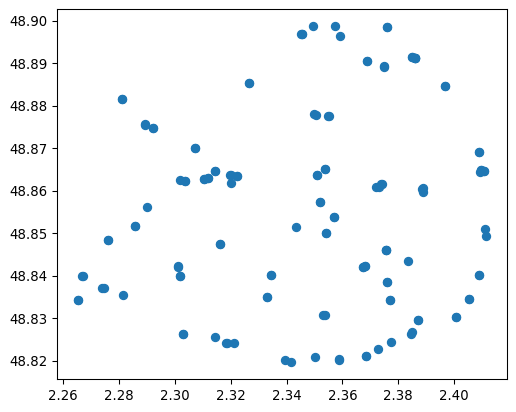

<div class="alert alert-danger" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left: .2rem solid #ff0039;">
<h3 class="alert-heading"><i class="fa fa-exclamation-triangle"></i> Warning</h3>

On serait tenté de faire un *merge* de la base compteurs et comptages.
En l’occurrence, il s’agirait d’un produit cartésien puisqu’il s’agit de faire exploser la base spatiale.
Avec des données spatiales, c’est souvent une très mauvaise idée. Cela duplique les points, créant des difficultés à représenter les données mais aussi ralentit les calculs.
Sauf à utiliser la méthode `dissolve` (qui va agréger *k* fois la même géométrie…), les géométries sont perdues lorsqu’on effectue des `groupby`.

</div>

Maintenant, tout est prêt pour une première carte. `matplotlib` fonctionne selon
le principe des couches. On va de la couche la plus lointaine à celle le plus
en surface. L’exception est lorsqu’on ajoute un fond de carte `contextily` via
`ctx.add_basemap`: on met cet appel en dernier.

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 2: Première carte</h3>

Représenter une carte des `compteurs` avec le fonds de carte des `arrondissements`

-   Faire attention à avoir des arrondissements dont l’intérieur est transparent (argument à utiliser: `facecolor`).
-   Faire des bordures d’arrondissements noires et affichez les compteurs en rouge.
-   Pour obtenir un graphique plus grand, vous pouvez utiliser l’argument `figsize = (10,10)`.
-   Pour les localisations, les points doivent être rouges en étant plus transparent au centre (argument à utiliser: `alpha`)

</div>

Vous devriez obtenir cette carte:

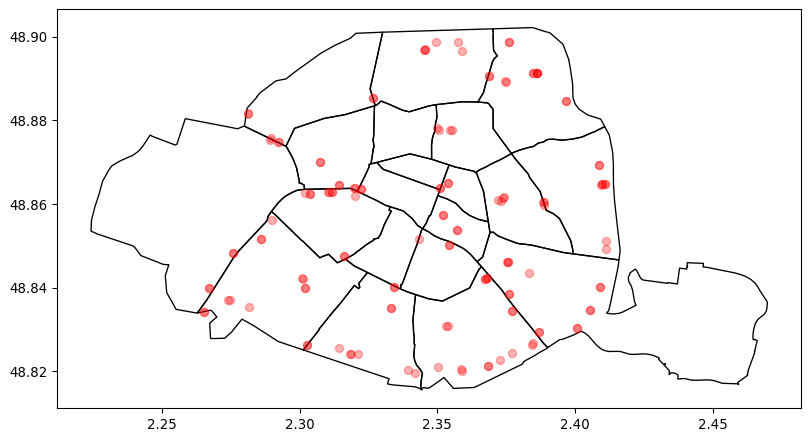

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 3 : Ajouter un fonds de carte avec contextily</h3>

Repartir de la carte précédente.

1.  Utiliser `ctx.add_basemap` pour ajouter un fonds de carte. Pour ne pas afficher les axes, vous pouvez utiliser `ax.set_axis_off()`.

:warning: *Par défaut, `contextily` désire un système de projection (crs) qui est le Web Mercator (epsg: 3857). Il faut changer la valeur de l’argument `crs`.*

:warning: *Avec les versions anciennes des packages, il faut utiliser `.to_string` sur un objet CRS pour qu’il soit reconnu par `contextily`. Sur des versions récentes, la valeur numérique du code EPSG est suffisante.*

1.  Trouver un fonds de carte plus esthétique, qui permette de visualiser les grands axes, parmi ceux possibles. Pour tester l’esthétique, vous pouvez utiliser [cet url](http://leaflet-extras.github.io/leaflet-providers/preview/index.html). La documentation de référence sur les tuiles disponibles est [ici](https://contextily.readthedocs.io/en/latest/providers_deepdive.html)

</div>

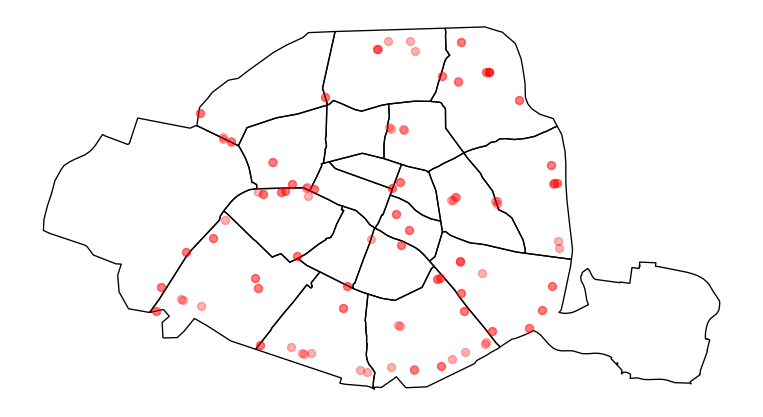

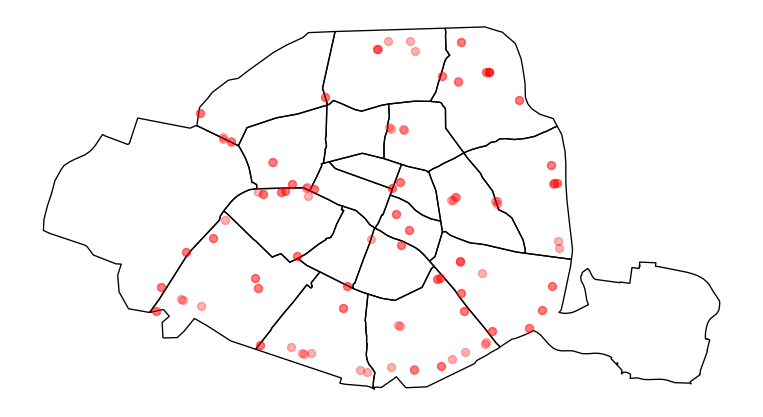

Le principe de la *heatmap* est de construire, à partir d’un nuage de point bidimensionnel, une distribution 2D lissée. La méthode repose sur les estimateurs à noyaux qui sont des méthodes de lissage local.

<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Exercice 3 : Ajouter un fonds de carte avec contextily</h3>

Pour le moment, la fonction `geoplot.kdeplot` n’incorpore pas toutes les fonctionalités de `seaborn.kdeplot`. Pour être en mesure de construire une `heatmap` avec des données pondérées (cf. [cette issue dans le dépôt seaborn](https://github.com/mwaskom/seaborn/issues/1364)), il y a une astuce. Il faut simuler *k* points de valeur 1 autour de la localisation observée. La fonction ci-dessous, qui m’a été bien utile, est pratique et est donnée pour vous aider.

</div>

In [15]:
import numpy as np


def expand_points(
    shapefile, index_var="grid_id", weight_var="prop", radius_sd=100, crs=2154
):
    """
    Multiply number of points to be able to have a weighted heatmap
    :param shapefile: Shapefile to consider
    :param index_var: Variable name to set index
    :param weight_var: Variable that should be used
    :param radius_sd: Standard deviation for the radius of the jitter
    :param crs: Projection system that should be used. Recommended option
      is Lambert 93 because points will be jitterized using meters
    :return:
      A geopandas point object with as many points by index as weight
    """

    shpcopy = shapefile
    shpcopy = shpcopy.set_index(index_var)
    shpcopy["npoints"] = np.ceil(shpcopy[weight_var])
    shpcopy["geometry"] = shpcopy["geometry"].centroid
    shpcopy["x"] = shpcopy.geometry.x
    shpcopy["y"] = shpcopy.geometry.y
    shpcopy = shpcopy.to_crs(crs)
    shpcopy = shpcopy.loc[np.repeat(shpcopy.index.values, shpcopy.npoints)]
    shpcopy["x"] = shpcopy["x"] + np.random.normal(0, radius_sd, shpcopy.shape[0])
    shpcopy["y"] = shpcopy["y"] + np.random.normal(0, radius_sd, shpcopy.shape[0])

    gdf = gpd.GeoDataFrame(
        shpcopy, geometry=gpd.points_from_xy(shpcopy.x, shpcopy.y), crs=crs
    )

    return gdf


<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 4 : Data cleaning avant de pouvoir faire une heatmap</h3>

1.  Calculer le trafic moyen, pour chaque station, entre 7 heures et 10 heures (bornes incluses) et nommer cet objet `df1`. Faire la même chose, en nommant `df2`, pour le trafic entre 17 et 20 heures (bornes incluses)

2.  Nous allons désormais préparer les données de manière à faire une heatmap. Après avoir compris ce que permet de faire la fonction `expand_points` ci-dessus, créer une fonction `explode_data` qui suive les étapes suivantes.

-   Convertir un DataFrame dans le système de projection Lambert 93 (epsg: 2154)
-   Appliquer `expand_points` aux noms de variable adéquats. Vous pouvez fixer la valeur de `radius_sd` à `100`.
-   Reconvertir l’output au format WGS84 (epsg: 4326)

1.  Appliquer cette fonction à `df1` et `df2`

</div>

# 2. Des cartes réactives grâce à `folium`

De plus en plus d’applications de visualisation reposent sur la cartographie réactive. Que ce soit dans l’exploration des données ou dans la représentation finale de résultats, la cartographie réactive est très appréciable.

`folium` offre une interface très flexible et très facile à prendre à main. Les cartes sont construites grâce à la librairie JavaScript `Leaflet.js` mais, sauf si on désire aller loin dans la customisation du résultat, il n’est pas nécessaire d’avoir des notions dans le domaine.

Un objet folium se construit par couche. La première est l’initialisation de la carte. Les couches suivantes sont les éléments à mettre en valeur. L’initialisation de la carte nécessite la définition d’un point central (paramètre `location`) et d’un zoom de départ (`zoom_start`). Plutôt que de fournir manuellement le point central et le zoom on peut :

1.  Déterminer le point central en construisant des colonnes longitudes et latitudes et en prenant la moyenne de celles-ci ;
2.  Utiliser la méthode `fit_bounds` qui cale la carte sur les coins sud-ouest et nord-est. En supposant que la carte s’appelle `m`, on fera `m.fit_bounds([sw, ne])`

Le bout de code suivant permet de calculer le centre de la carte

In [19]:
compteurs = gpd.read_file(
    "https://parisdata.opendatasoft.com/api/explore/v2.1/catalog/datasets/comptage-velo-compteurs/exports/geojson?lang=fr&timezone=Europe%2FBerlin"
)
compteurs["lon"] = compteurs.geometry.x
compteurs["lat"] = compteurs.geometry.y
center = compteurs[["lat", "lon"]].mean().values.tolist()
print(center)


[48.855656572463765, 2.3476786666666665]

Alors que le code suivant permet de calculer les coins:

In [20]:
sw = compteurs[["lat", "lon"]].min().values.tolist()
ne = compteurs[["lat", "lon"]].max().values.tolist()
print(sw, ne)


[48.81964, 2.26526] [48.898728, 2.41143]

<div class="alert alert-warning" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #ffc10780;">
<h3 class="alert-heading"><i class="fa fa-lightbulb-o"></i> Hint</h3>

Si un fond gris s’affiche, c’est qu’il y a un problème de localisation ou d’accès à internet. Pour le premier cas, cela provient généralement d’un problème de projection ou d’une inversion des longitudes et latitudes.

Les longitudes représentent les *x* (axe ouest-est) et les latitudes *y* (axe sud-nord). De manière contrintuitive, `folium` attend qu’on lui fournisse les données sous la forme `[latitude, longitude]` donc `[y,x]`

</div>

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 6 : Visualiser la localisation des stations</h3>

1.  Calculer le centre `center`de la carte des données `compteurs`. Il s’obtient en agrègeant l’ensemble des géométries, calculant le centroid et récupèrant la valeur sous forme de liste. Avec une logique similaire, calculez les bornes du sud-ouest `sw` et du nord-est `ne` de la carte.
2.  Représenter la localisation des stations en utilisant un zoom optimal.

</div>

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<html>
<head>
 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-3.7.1.min.js"></script>
 <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@fortawesome/fontawesome-free@6.2.0/css/all.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_552fc3045a66b3e59fdef58dc1234aea {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 .leaflet-container { font-size: 1rem; }
 </style>
 
</head>
<body>
 
 
 <div class="folium-map" id="map_552fc3045a66b3e59fdef58dc1234aea" ></div>
 
</body>
<script>
 
 
 var map_552fc3045a66b3e59fdef58dc1234aea = L.map(
 "map_552fc3045a66b3e59fdef58dc1234aea",
 {
 center: [48.855656572463765, 2.3476786666666665],
 crs: L.CRS.EPSG3857,
 zoom: 10,
 zoomControl: true,
 preferCanvas: false,
 }
 );

 

 
 
 var tile_layer_f7b9b13ddd7778869dc4a6a0f1820ebe = L.tileLayer(
 "https://tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "\u0026copy; \u003ca href=\"https://www.openstreetmap.org/copyright\"\u003eOpenStreetMap\u003c/a\u003e contributors", "detectRetina": false, "maxNativeZoom": 19, "maxZoom": 19, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 );
 
 
 tile_layer_f7b9b13ddd7778869dc4a6a0f1820ebe.addTo(map_552fc3045a66b3e59fdef58dc1234aea);
 
 
 var marker_4bc7bb107945c9b0ebf4b93a72202cd8 = L.marker(
 [48.83504, 2.33314],
 {}
 ).addTo(map_552fc3045a66b3e59fdef58dc1234aea);
 
 
 var popup_94526e4d9ab7ccb253dc9c1213055de6 = L.popup({"maxWidth": "100%"});

 
 
 var html_33c89713fa487e8ee7ab9d1f89654404 = $(`<div id="html_33c89713fa487e8ee7ab9d1f89654404" style="width: 100.0%; height: 100.0%;">97 avenue Denfert Rochereau SO-NE</div>`)[0];
 popup_94526e4d9ab7ccb253dc9c1213055de6.setContent(html_33c89713fa487e8ee7ab9d1f89654404);
 
 

 marker_4bc7bb107945c9b0ebf4b93a72202cd8.bindPopup(popup_94526e4d9ab7ccb253dc9c1213055de6)
 ;

 
 
 
 var marker_65aa27997690c12416c9523743bfae88 = L.marker(
 [48.87773, 2.3506],
 {}
 ).addTo(map_552fc3045a66b3e59fdef58dc1234aea);
 
 
 var popup_99723cb53e99fcc795d1fd1c2d056a13 = L.popup({"maxWidth": "100%"});

 
 
 var html_24aadf1f03db24ef7be4ee98aace454b = $(`<div id="html_24aadf1f03db24ef7be4ee98aace454b" style="width: 100.0%; height: 100.0%;">105 rue La Fayette E-O</div>`)[0];
 popup_99723cb53e99fcc795d1fd1c2d056a13.setContent(html_24aadf1f03db24ef7be4ee98aace454b);
 
 

 marker_65aa27997690c12416c9523743bfae88.bindPopup(popup_99723cb53e99fcc795d1fd1c2d056a13)
 ;

 
 
 
 var marker_91966fc0e2d2368d7b4134b9235efd4c = L.marker(
 [48.83507, 2.33305],
 {}
 ).addTo(map_552fc3045a66b3e59fdef58dc1234aea);
 
 
 var popup_3a6c0197f94774af164640b5f9333d80 = L.popup({"maxWidth": "100%"});

 
 
 var 

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 7: Représenter les stations</h3>

Faire la même carte, avec des ronds proportionnels au nombre de comptages :

-   Pour le rayon de chaque cercle, vous pouvez appliquer la règle `500*x/max(x)` (règle au doigt mouillé)
-   Vous pouvez réduire la taille des bordures de cercle avec l’option `weight = 1` et fixer la couleur avec `color = 'grey'`
-   (Optionnel) Colorer en rouge les 10 plus grosses stations. L’opacité étant, par défaut, un peu faible, le paramètre `fill_opacity = 0.4` améliore le rendu.
-   (Optionnel) Afficher, en supplément du nom du compteur lorsqu’on clique, la valeur du comptage en revenant à la ligne

</div>

La carte obtenue doit ressembler à la suivante :

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<html>
<head>
 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-3.7.1.min.js"></script>
 <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@fortawesome/fontawesome-free@6.2.0/css/all.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_eec5a08e147383a19c20f2f10cb4ac7f {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 .leaflet-container { font-size: 1rem; }
 </style>
 
</head>
<body>
 
 
 <div class="folium-map" id="map_eec5a08e147383a19c20f2f10cb4ac7f" ></div>
 
</body>
<script>
 
 
 var map_eec5a08e147383a19c20f2f10cb4ac7f = L.map(
 "map_eec5a08e147383a19c20f2f10cb4ac7f",
 {
 center: [48.85329604444444, 2.349276577777778],
 crs: L.CRS.EPSG3857,
 zoom: 10,
 zoomControl: true,
 preferCanvas: false,
 }
 );

 

 
 
 var tile_layer_7f315a6f67e2ad0097fc5a3ecb2adfe8 = L.tileLayer(
 "https://tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "\u0026copy; \u003ca href=\"https://www.openstreetmap.org/copyright\"\u003eOpenStreetMap\u003c/a\u003e contributors", "detectRetina": false, "maxNativeZoom": 19, "maxZoom": 19, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 );
 
 
 tile_layer_7f315a6f67e2ad0097fc5a3ecb2adfe8.addTo(map_eec5a08e147383a19c20f2f10cb4ac7f);
 
 
 var circle_f7dc1bc9f9d8bafe06fbcf92ff3a7128 = L.circle(
 [48.84613, 2.37559],
 {"bubblingMouseEvents": true, "color": "grey", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "green", "fillOpacity": 0.4, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 500.0, "stroke": true, "weight": 1}
 ).addTo(map_eec5a08e147383a19c20f2f10cb4ac7f);
 
 
 var popup_f48c67ab86964684a355f98db1c2fb9d = L.popup({"maxWidth": "100%"});

 
 
 var html_445d88dcd77f4374e35cead98c7ed9ec = $(`<div id="html_445d88dcd77f4374e35cead98c7ed9ec" style="width: 100.0%; height: 100.0%;">28 boulevard Diderot O-E: <br> 44.0</div>`)[0];
 popup_f48c67ab86964684a355f98db1c2fb9d.setContent(html_445d88dcd77f4374e35cead98c7ed9ec);
 
 

 circle_f7dc1bc9f9d8bafe06fbcf92ff3a7128.bindPopup(popup_f48c67ab86964684a355f98db1c2fb9d)
 ;

 
 
 
 var circle_39030796b27ac53e81a8146df3120c80 = L.circle(
 [48.84613, 2.37559],
 {"bubblingMouseEvents": true, "color": "grey", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "green", "fillOpacity": 0.4, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 500.0, "stroke": true, "weight": 1}
 ).addTo(map_eec5a08e147383a19c20f2f10cb4ac7f);
 
 
 var popup_b54eaef8524f42ad134f8cd610331af2 = L.popup({"maxWidth": "100%"});

 
 
 var html_9841a9ba01ab9120d2007e5b7489f727 = $(`<div id="h

# 3. Exercices supplémentaires

## 3.1 Densité de population dans la petite couronne parisienne

Pour cet exercice, le package [`cartiflette`](https://github.com/InseeFrLab/cartogether)
va être pratique pour récupérer un fonds de carte mélangeant arrondissements
parisiens et communes dans les autres villes.

Nous allons privilégier une carte à ronds proportionnels (*bubble map*)
aux cartes chorolèpthes qui trompent
l’oeil.

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice: bubble map de densité des populations</h3>

1.  Récupérer le fond de carte des départements 75, 92, 93 et 94
    avec `cartiflette`. Pour cela, utiliser `carti_download`
    depuis `cartiflette` en fixant l’option `borders` à `COMMUNE_ARRONDISSEMENT`.
    Nommer cet objet `df`.
2.  Afin que les calculs ultérieurs de surface ne soient pas faussés,
    assurez-vous que les données sont en Lambert 93 en reprojetant
    nos contours (code EPSG: 2154).
3.  Créer un objet `departements` avec `dissolve` pour également disposer
    d’un fond de carte des départements
4.  Créer une variable `surface` et utilisant la méthode `area`. L’unité
    doit être le km², il faut donc diviser par $10^6$
5.  Créer une variable `densite`
6.  Utiliser `pd.cut` avec les seuils 5000, 15000 et 30000 personnes
    par km². Vous pouvez utiliser l’option `label` pour dénommer les tranches
7.  Créer un `GeoDataFrame` de points en utilisant la méthode centroid. Celui-ci
    nous servira à localiser le centre de nos ronds.
8.  Représenter la densité communale sous forme de carte avec ronds proportionnels.
    Vous pouvez utiliser la variable créée à la question 5 pour les couleurs.

</div>

La carte obtenue devrait ressembler à celle-ci :

Text(0.3, 0.15, 'Source: IGN - AdminExpress')

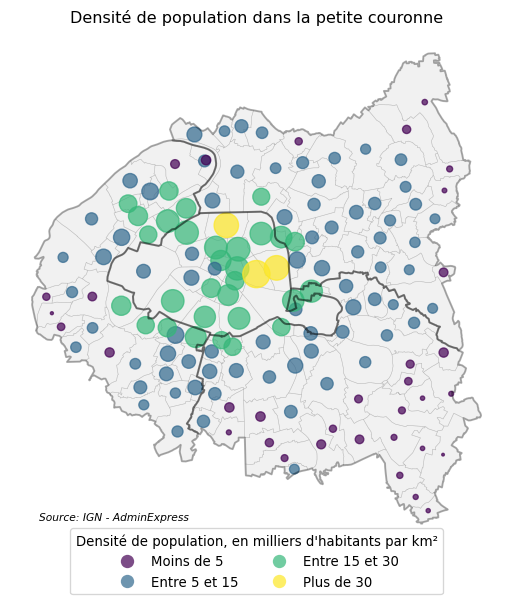

# Références supplémentaires

-   *[Geocomputation with `Python`](https://geocompx.org/)*